# exp003
[Notion](https://www.notion.so/exp003-a53eb979c0de4167818d17c5f0342e39?pvs=4)  
exp002で作成したデータセットの確認

In [25]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import pydicom
import warnings
from tqdm import tqdm

%matplotlib inline
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 70
warnings.filterwarnings("ignore")

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')
    
from src.data_io import load_dicom_series
from src.image_processing import windowing

In [6]:
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_series_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

base_dir = "data/rsna-2023-abdominal-trauma-detection"
dataset_dir = "data/dataset001"

In [91]:
def load_series_from_dataset(dir_: str)-> np.ndarray:
    """seriesを読み込む."""
    path_list = os.listdir(dir_)
    path_list = [[int(path.replace(".npy","")), path] for path in path_list]
    path_list.sort()
    path_list = [path[1] for path in path_list]
    arr = []
    for path in path_list:
        arr.append(np.load(os.path.join(dir_, path)))
    return np.array(arr)

def print_injury(df:pd.DataFrame, pid: int) -> None:
    """pid, sidの患者の損傷情報を表示する."""
    tmp = df[(df["patient_id"] == pid)].iloc[0]
    info = ""
    if tmp["bowel_injury"]:
        info += "bowel_injury \n"
    if tmp["extravasation_injury"]:
        info += "extravasation_injury \n"
    for organ in ["kidney", "liver", "spleen"]:
        for grade in ["low", "high"]:
            if tmp[f"{organ}_{grade}"]:
                info += f"{organ}_{grade} \n"
    if info == "":
        info = "healty patient"
    else:
        info = "===injury information===\n" + info
    print(info)

def animate(ims):
    skip = 1
    if len(ims) > 200:
        skip = len(ims)//200
        ims = ims[::skip]
    fig,ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    frame = ax.text(450,20,"1",size=15,color="white")
    im = ax.imshow(ims[0],cmap="gray")
    
    def animate_func(i):
        im.set_array(ims[i])
        frame.set_text(str(i*skip+1))
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

In [87]:
df_train[df_train["kidney_high"] == 1]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
136,12600,1,0,1,0,0,0,1,0,0,1,1,0,0,1
161,13098,1,0,1,0,0,0,1,1,0,0,1,0,0,1
168,13241,1,0,0,1,0,0,1,1,0,0,1,0,0,1
200,13794,1,0,1,0,0,0,1,0,1,0,1,0,0,1
219,14309,1,0,1,0,0,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782,61547,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2810,62116,1,0,0,1,0,0,1,1,0,0,0,0,1,1
2815,62246,1,0,1,0,0,0,1,1,0,0,0,0,1,1
2838,62845,1,0,1,0,0,0,1,0,1,0,1,0,0,1


In [89]:
df_train_series_meta[df_train_series_meta["patient_id"]==12600]

,patient_id,series_id,aortic_hu,incomplete_organ
199,12600,3309,185.0,0


In [90]:
idx = 199
pid, sid = df_train_series_meta["patient_id"][idx], df_train_series_meta["series_id"][idx]
print(f"patient_id: {pid}, series_id: {sid}")
print_injury(df_train, pid)
dir_ = f"{dataset_dir}/train_images/{pid}/{sid}"
arr = load_series_from_dataset(dir_)
arr_ww = windowing(arr)

patient_id: 12600, series_id: 3309
===injury information===
kidney_high 
liver_high 



In [ ]:
# 保存時はこのセルの出力を消すこと。(ファイルサイズが大きくなるため)
animate(arr_ww)

patient_id: 10132, series_id: 4816
===injury information===
spleen_high 



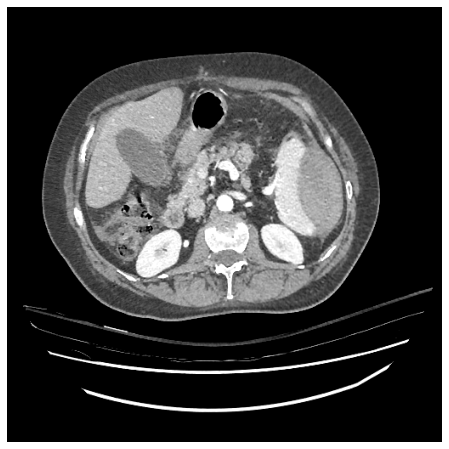

In [78]:
idx = 16
pid, sid = df_train_series_meta["patient_id"][idx], df_train_series_meta["series_id"][idx]
print(f"patient_id: {pid}, series_id: {sid}")
print_injury(df_train, pid)
dir_ = f"{dataset_dir}/train_images/{pid}/{sid}"
arr = load_series_from_dataset(dir_)
arr_ww = windowing(arr)
injury_slice = 225
plt.figure(figsize=(8, 8))
plt.imshow(arr_ww[injury_slice], cmap="gray")
plt.axis(False)
plt.show()

patient_id: 10163, series_id: 17557
===injury information===
liver_low 



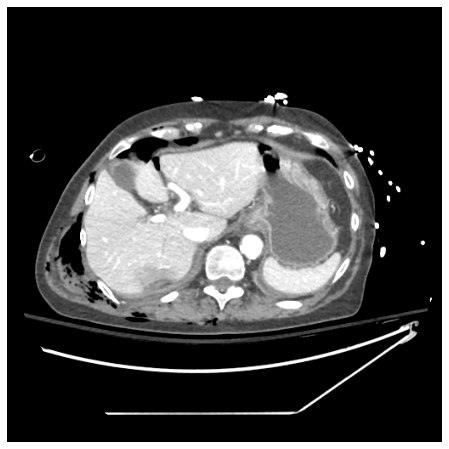

In [79]:
idx = 17
pid, sid = df_train_series_meta["patient_id"][idx], df_train_series_meta["series_id"][idx]
print(f"patient_id: {pid}, series_id: {sid}")
print_injury(df_train, pid)
dir_ = f"{dataset_dir}/train_images/{pid}/{sid}"
arr = load_series_from_dataset(dir_)
arr_ww = windowing(arr)
injury_slice = 66
plt.figure(figsize=(8, 8))
plt.imshow(arr_ww[injury_slice], cmap="gray")
plt.axis(False)
plt.show()

patient_id: 10217, series_id: 16066
===injury information===
extravasation_injury 
liver_low 
spleen_high 



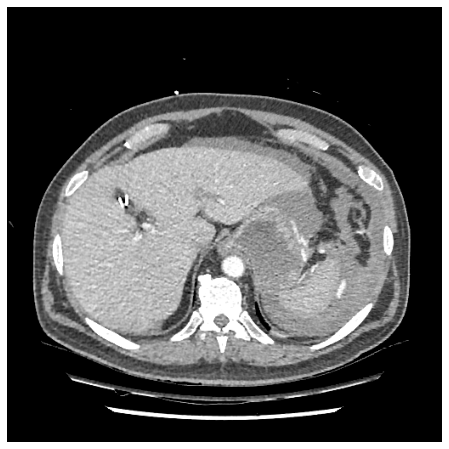

In [85]:
idx = 21
pid, sid = df_train_series_meta["patient_id"][idx], df_train_series_meta["series_id"][idx]
print(f"patient_id: {pid}, series_id: {sid}")
print_injury(df_train, pid)
dir_ = f"{dataset_dir}/train_images/{pid}/{sid}"
arr = load_series_from_dataset(dir_)
arr_ww = windowing(arr)
injury_slice = 144
plt.figure(figsize=(8, 8))
plt.imshow(arr_ww[injury_slice], cmap="gray")
plt.axis(False)
plt.show()

patient_id: 12600, series_id: 3309
===injury information===
kidney_high 
liver_high 



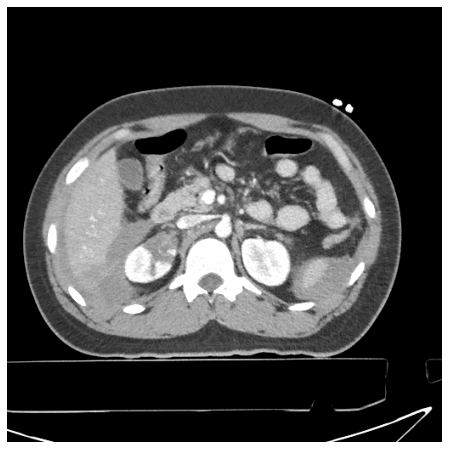

In [93]:
idx = 199
pid, sid = df_train_series_meta["patient_id"][idx], df_train_series_meta["series_id"][idx]
print(f"patient_id: {pid}, series_id: {sid}")
print_injury(df_train, pid)
dir_ = f"{dataset_dir}/train_images/{pid}/{sid}"
arr = load_series_from_dataset(dir_)
arr_ww = windowing(arr)
injury_slice = 98
plt.figure(figsize=(8, 8))
plt.imshow(arr_ww[injury_slice], cmap="gray")
plt.axis(False)
plt.show()

patient_id: 12600, series_id: 3309
===injury information===
kidney_high 
liver_high 



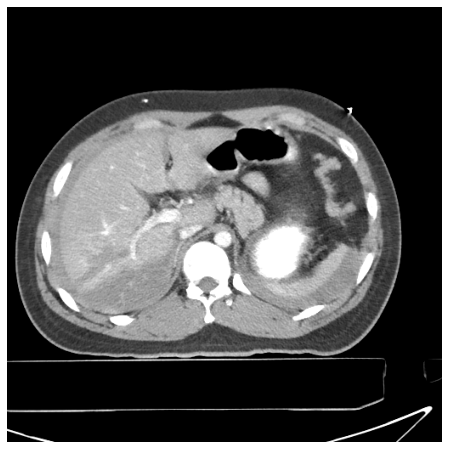

In [94]:
idx = 199
pid, sid = df_train_series_meta["patient_id"][idx], df_train_series_meta["series_id"][idx]
print(f"patient_id: {pid}, series_id: {sid}")
print_injury(df_train, pid)
dir_ = f"{dataset_dir}/train_images/{pid}/{sid}"
arr = load_series_from_dataset(dir_)
arr_ww = windowing(arr)
injury_slice = 73
plt.figure(figsize=(8, 8))
plt.imshow(arr_ww[injury_slice], cmap="gray")
plt.axis(False)
plt.show()